In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing

In [2]:
# Load train data

fraud_data = pd.read_csv('data/imbalancedFraudDF.csv')
ip_country_ref = pd.read_csv('data/IpAddress_to_Country.csv')

fraud_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
3,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0
4,159135,2015-05-21 06:03:03,2015-07-09 08:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0


In [3]:
# Show the distribution of labels
# Find data is highly imbalanced

row_num = fraud_data.shape[0]
fraud_rate = fraud_data['class'].value_counts() / row_num


In [4]:
fraud_rate

class
0    0.989774
1    0.010226
Name: count, dtype: float64

In [5]:
# Identify contry from ip address

ip_country_ref.head()

countries = []
for i  in range(len(fraud_data)):
    ip_address = fraud_data.loc[i, 'ip_address']

    tmp = ip_country_ref[(ip_address >= ip_country_ref['lower_bound_ip_address']) &
                         (ip_address <= ip_country_ref['upper_bound_ip_address'])]
    if len(tmp) == 1:
        countries.append(tmp['country'].values[0])
    else:
        countries.append('NA')

fraud_data['country'] = countries




In [6]:
fraud_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA
3,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States
4,159135,2015-05-21 06:03:03,2015-07-09 08:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0,Canada


In [7]:
# Extract hours from signup_time and purchase_time

fraud_data['signup_timestamp'] = pd.to_datetime(fraud_data['signup_time'])

fraud_data['purchase_timestamp'] = pd.to_datetime(fraud_data['purchase_time'])

fraud_data['signup_hour'] = fraud_data['signup_timestamp'].dt.hour

fraud_data['purchase_hour'] = fraud_data['purchase_timestamp'].dt.hour

fraud_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,signup_timestamp,purchase_timestamp,signup_hour,purchase_hour
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,2015-02-24 22:55:49,2015-04-18 02:47:11,22,2
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,2015-06-07 20:39:50,2015-06-08 01:38:54,20,1
2,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA,2015-04-28 21:13:25,2015-05-04 13:54:50,21,13
3,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,2015-07-21 07:09:52,2015-09-09 18:40:53,7,18
4,159135,2015-05-21 06:03:03,2015-07-09 08:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0,Canada,2015-05-21 06:03:03,2015-07-09 08:05:14,6,8


Text(0, 0.5, 'Number of Sign-ups')

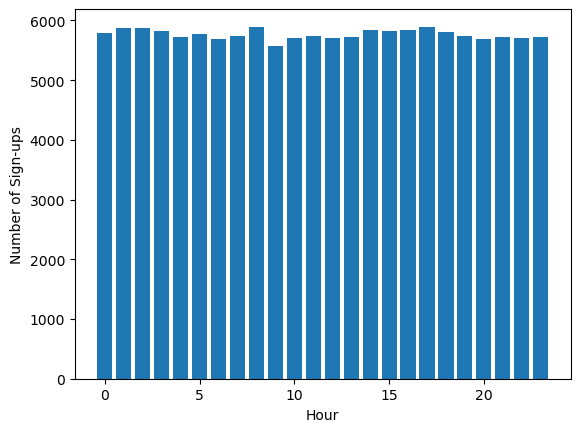

In [8]:
# Sign-ups were evenly distributed across hours

signup_by_hour = fraud_data.groupby('signup_hour').size().reset_index(name = 'count')

plt.bar(signup_by_hour['signup_hour'], signup_by_hour['count'])

plt.xlabel('Hour')
plt.ylabel('Number of Sign-ups')


Text(0, 0.5, 'Number of Purchases')

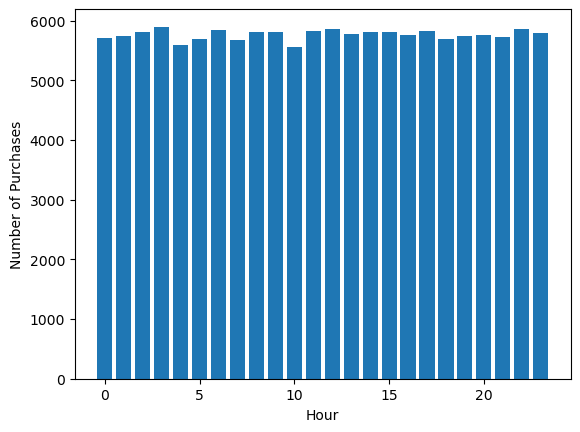

In [9]:
purchase_by_hour = fraud_data.groupby('purchase_hour').size().reset_index(name = 'count')

plt.bar(purchase_by_hour['purchase_hour'], purchase_by_hour['count'])

plt.xlabel('Hour')
plt.ylabel('Number of Purchases')

Text(0, 0.5, 'Number of Purchases')

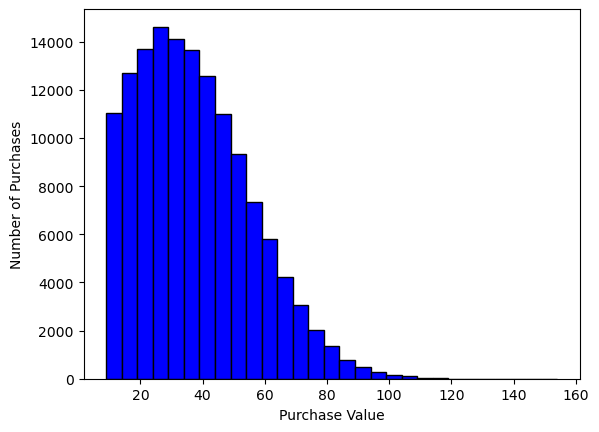

In [10]:
# Plot distribution of purchase values

fraud_data['purchase_value'].describe()

plt.hist(fraud_data['purchase_value'], color = 'blue', edgecolor = 'black',
         bins = int((fraud_data['purchase_value'].max() - fraud_data['purchase_value'].min()) / 5))

plt.xlabel('Purchase Value')
plt.ylabel('Number of Purchases')

{'whiskers': [<matplotlib.lines.Line2D at 0x16b505250>,
 'caps': [<matplotlib.lines.Line2D at 0x16b506390>,
 'boxes': [<matplotlib.lines.Line2D at 0x16b463e10>],
 'medians': [<matplotlib.lines.Line2D at 0x16b507490>],
 'fliers': [<matplotlib.lines.Line2D at 0x16b507d10>],
 'means': []}

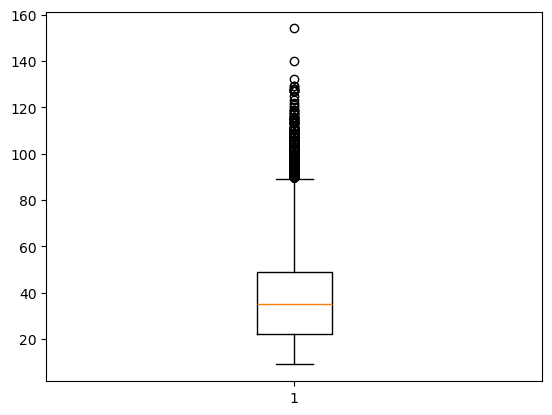

In [11]:
# Use box plot to show outliers

plt.boxplot(fraud_data['purchase_value'])

In [12]:
# Calculate quartiles of purchase values

purchase_val_p25 = np.percentile(fraud_data['purchase_value'], 25)
purchase_val_p50 = np.percentile(fraud_data['purchase_value'], 50)
purchase_val_p75 = np.percentile(fraud_data['purchase_value'], 75)

lower_bound = purchase_val_p25 - 1.5 * (purchase_val_p75 - purchase_val_p25)
upper_bound = purchase_val_p75 + 1.5 * (purchase_val_p75 - purchase_val_p25)

print(lower_bound)
print(upper_bound) # Purchase values greater than 89.5 are outliers

-18.5
89.5


In [ ]:
# Show top 10 countries with highest percentages of fraud transactions

purchase_by_countryip = fraud_data.groupby('country')['class'].value_counts(normalize=True).mul(100).round(2).reset_index(name = 'percentage')

purchase_by_countryip[purchase_by_countryip['class'] == 1].sort_values(by = 'percentage', ascending = False)[:10]


,country,class,percentage
241,Uzbekistan,1,11.11
211,Sri Lanka,1,10.00
134,Luxembourg,1,6.38
178,Peru,1,5.38
233,United Arab Emirates,1,4.85
226,Tunisia,1,4.40
161,New Zealand,1,4.00
132,Lithuania,1,3.75
68,Ecuador,1,3.70
109,Ireland,1,3.14


In [ ]:
# Show percentages of fraud transactions by browser used

purchase_by_browser = fraud_data.groupby('browser')['class'].value_counts(normalize = True).mul(100).round(2).reset_index(name = 'percentage')

purchase_by_browser[purchase_by_browser['class'] == 1].sort_values(by = 'percentage', ascending = False)

# Transactions using Chrome browser had the highest share of fraud

,browser,class,percentage
1,Chrome,1,1.13
3,FireFox,1,1.03
9,Safari,1,1.01
5,IE,1,0.87
7,Opera,1,0.86


In [ ]:
# Show percentages of fraud transactions by source

purchase_by_source = fraud_data.groupby('source')['class'].value_counts(normalize = True).mul(100).round(2).reset_index(name = 'percentage')

purchase_by_source # Direct purchases has the highest fraud rate

,source,class,percentage
0,Ads,0,99.01
1,Ads,1,0.99
2,Direct,0,98.89
3,Direct,1,1.11
4,SEO,0,98.99
5,SEO,1,1.01


In [ ]:
# Feature engineering: calculate time interval between signup and first purchase
# check if there was bed time operation

fraud_data['interval_after_signup'] = (fraud_data['purchase_timestamp'] -
                                       fraud_data['signup_timestamp']).dt.total_seconds() # Calculate in seconds

fraud_data['signup_days_of_year'] = pd.DatetimeIndex(fraud_data['signup_time']).dayofyear # Get signup day of year

fraud_data['signup_seconds_of_day'] = pd.DatetimeIndex(fraud_data['signup_time']).second + 60 * pd.DatetimeIndex(
    fraud_data['signup_time']).minute + 3600 * pd.DatetimeIndex(fraud_data['signup_time']).hour

fraud_data['purchase_days_of_year'] = pd.DatetimeIndex(fraud_data['purchase_time']).dayofyear # Get purchase day of year
fraud_data['purchase_seconds_of_day'] = pd.DatetimeIndex(fraud_data['purchase_time']).second + 60 * pd.DatetimeIndex(
    fraud_data['purchase_time']).minute + 3600 * pd.DatetimeIndex(fraud_data['purchase_time']).hour

fraud_data = fraud_data.drop(['signup_time', 'purchase_time', 'signup_hour', 'purchase_hour', 'signup_timestamp', 'purchase_timestamp'], axis = 1)


In [28]:
fraud_data = fraud_data.drop(['user_id'], axis = 1)

In [29]:
# Split labels and features

y = fraud_data['class']
X = fraud_data.drop(['class'], axis = 1)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

print('X_train.shape:', X_train.shape)
print('y_train.shape:', y_train.shape)

X_train.shape: (110700, 13)
y_train.shape: (110700,)


In [30]:
X_train.head()

,purchase_value,device_id,source,browser,sex,age,ip_address,country,interval_after_signup,signup_days_of_year,signup_seconds_of_day,purchase_days_of_year,purchase_seconds_of_day
11069,75,JXYDDVEWLVUNH,Ads,Chrome,M,19,9.531589e+08,United States,2301029.0,212,4497,238,59126
134605,41,LIKKYNLACXDPL,Ads,Safari,M,48,2.924818e+08,United States,643232.0,73,30813,80,69245
81376,44,HAUGCLFTDVGSP,SEO,IE,M,29,8.760517e+08,United States,5611996.0,7,58773,72,54769
51555,9,EAHWZQBXBOXNN,SEO,Safari,F,45,1.595682e+08,United States,5459844.0,217,26362,280,43006
132464,40,SHTMXMXSEQIYO,Ads,IE,M,36,1.599895e+09,Portugal,8522428.0,119,54456,218,23284


In [31]:
# Transform categorical variables

from sklearn.preprocessing import OneHotEncoder

def OneHotEncoding(df, enc, categories):
    # Covert sparse matrix to ndarray
    transformed = pd.DataFrame(enc.transform(df[categories]).toarray(), columns=enc.get_feature_names_out(categories))
    return pd.concat([df.reset_index(drop=True), transformed], axis=1).drop(categories, axis=1)

categories = ['source', 'browser']
enc_ohe = OneHotEncoder()
enc_ohe.fit(X_train[categories])

X_train = OneHotEncoding(X_train, enc_ohe, categories)
X_test = OneHotEncoding(X_test, enc_ohe, categories)

In [32]:
X_train.head()

,purchase_value,device_id,sex,age,ip_address,country,interval_after_signup,signup_days_of_year,signup_seconds_of_day,purchase_days_of_year,purchase_seconds_of_day,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari
0,75,JXYDDVEWLVUNH,M,19,9.531589e+08,United States,2301029.0,212,4497,238,59126,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,41,LIKKYNLACXDPL,M,48,2.924818e+08,United States,643232.0,73,30813,80,69245,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,44,HAUGCLFTDVGSP,M,29,8.760517e+08,United States,5611996.0,7,58773,72,54769,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,9,EAHWZQBXBOXNN,F,45,1.595682e+08,United States,5459844.0,217,26362,280,43006,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,40,SHTMXMXSEQIYO,M,36,1.599895e+09,Portugal,8522428.0,119,54456,218,23284,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [33]:
X_train['sex'] = (X_train.sex == 'M').astype(int)

# Create variable: number of transactions using the same device
X_train_device_id_mapping = X_train.device_id.value_counts(dropna=False)
X_train['n_dev_shared'] = X_train.device_id.map(X_train_device_id_mapping)

# Create variable: number of transactions using the same ip address
X_train_ip_address_mapping = X_train.ip_address.value_counts(dropna = False)
X_train['n_ip_shared'] = X_train.ip_address.map(X_train_ip_address_mapping)

# Create variable: number of transacions from the same countries
X_train_country_mapping = X_train.country.value_counts(dropna=False)
X_train['n_country_shared'] = X_train.country.map(X_train_country_mapping)

X_train = X_train.drop(['device_id', 'ip_address', 'country'], axis = 1)

X_train.head()


,purchase_value,sex,age,interval_after_signup,signup_days_of_year,signup_seconds_of_day,purchase_days_of_year,purchase_seconds_of_day,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,n_dev_shared,n_ip_shared,n_country_shared
0,75,1,19,2301029.0,212,4497,238,59126,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1,42392
1,41,1,48,643232.0,73,30813,80,69245,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1,42392
2,44,1,29,5611996.0,7,58773,72,54769,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1,1,42392
3,9,0,45,5459844.0,217,26362,280,43006,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1,1,42392
4,40,1,36,8522428.0,119,54456,218,23284,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,178


In [34]:
X_test['sex'] = (X_test.sex == 'M').astype(int)

# Reason why we do not use the mappings for training data
# There will be too many NAs, especially for number of transactions shared by the same device
# and number of transactions shared by the same ip address
# We only have 1 transaction record for each user
# This is not a good practice in production, and we may only be able to use number of transactions from the same countries

X_test['n_dev_shared'] = X_test['device_id'].map(X_test['device_id'].value_counts(dropna = False))

X_test['n_ip_shared'] = X_test['ip_address'].map(X_test['ip_address'].value_counts(dropna = False))

X_test['n_country_shared'] = X_test['country'].map(X_test['country'].value_counts(dropna = False))

In [36]:
X_test = X_test.drop(['device_id', 'ip_address', 'country'], axis = 1)

X_test.head()

,purchase_value,sex,age,interval_after_signup,signup_days_of_year,signup_seconds_of_day,purchase_days_of_year,purchase_seconds_of_day,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,n_dev_shared,n_ip_shared,n_country_shared
0,43,1,25,7490418.0,70,53599,157,27217,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1,10631
1,48,1,24,2184644.0,35,60165,60,84809,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1,1,10631
2,31,1,29,2597852.0,228,78213,258,84065,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,1,10631
3,15,1,20,6923397.0,38,20868,118,32265,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,1,2250
4,83,1,34,6349399.0,228,42367,301,84566,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1,1,4105


In [38]:
# Normalize numerical features

numerical_cols = ['purchase_value', 'age', 'interval_after_signup',
                  'signup_days_of_year', 'signup_seconds_of_day',
                  'purchase_days_of_year', 'purchase_seconds_of_day',
                  'n_dev_shared', 'n_ip_shared', 'n_country_shared']

train_scaler = preprocessing.MinMaxScaler().fit(X_train[numerical_cols])

X_train[numerical_cols] = train_scaler.transform(X_train[numerical_cols])

X_test[numerical_cols] = train_scaler.transform(X_test[numerical_cols])

## Model Training

In [ ]:
logreg = LogisticRegression()

logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

In [ ]:
cm = metrics.confusion_matrix(y_test, y_pred)
cmDF = pd.DataFrame(cm, columns = ['pred_0', 'pred_1'],
                    index = ['true_0', 'true_1'])

print(cmDF)

In [ ]:
classifier_RF = RandomForestClassifier(random_state = 0)

classifier_RF.fit(X_train, y_train)

# Generate class raw probabilities
probs = classifier_RF.predict_proba(X_test)

# Generate class labels for test data
predicted = classifier_RF.predict(X_test)

# Generate evaluation metrics
print('%s: %r' % ('accuracy_score is: ', metrics.accuracy_score(y_test, predicted)))
print('%s: %r' % ('roc_auc_score is: ', metrics.roc_auc_score(y_test, probs[:, 1])))
print('%s: %r' % ('f1_score is: ', metrics.f1_score(y_test, predicted)))

print('confusion_matrix is: ')
cm_RF = metrics.confusion_matrix(y_test, predicted)
cm_RFDF = pd.DataFrame(cm_RF, columns = ['pred_0', 'pred_1'],
                       index = ['true_0', 'true_1'])

print(cm_RFDF)
print('recall =', float(cm[1,1]) / (cm[1,0] + cm[1,1])) # Recall = TP / (FN + TP)
print('precision =', float(cm[1,1]) / (cm[1,1] + cm[0,1])) # Precision = TP / (TP + FP)

In [ ]:
# Oversampling on training data only

smote = SMOTE(random_state = 2)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

unique, counts = np.unique(y_train_sm, return_counts = True)

print(np.asarray((unique, counts)).T)

In [ ]:
classifier_RF_sm = RandomForestClassifier(random_state = 0)

classifier_RF_sm.fit(X_train_sm, y_train_sm)

predicted_sm = classifier_RF_sm.predict(X_test)

probs_sm = classifier_RF_sm.predict_proba(X_test)

print('%s: %r' % ('accuracy_score_sm is: ', metrics.accuracy_score(y_test, predicted_sm)))
print('%s: %r' % ('roc_auc_score_sm is: ', metrics.roc_auc_score(y_test, probs_sm[:, 1])))
print('%s: %r' % ('f1_score_sm is: ', metrics.f1_score(y_test, predicted_sm)))

print('confusion_matrix_sm is: ')
cm_sm = metrics.confusion_matrix(y_test, predicted_sm)
cm_smDF = pd.DataFrame(cm_sm, columns = ['pred_0', 'pred_1'],
                       index = ['true_0', 'true_1'])

print(cm_smDF)
print('recall or sens_sm =', float(cm_sm))


